# Part 1 : Toy Neural Network Example

In this section we will walk through a complete implementation of a toy 
Neural Network in 2 dimensions. We will first implement a simple linear 
classifier and then extend the code to a $2$-layer Neural Network. As we 
will see, this extension is surprisingly simple and very few changes are 
necessary.

## Generating Spiral Dataset

Let us generate a classification dataset that is not easily linearly separable. Our favorite example is the spiral dataset, which can be generated as follows:


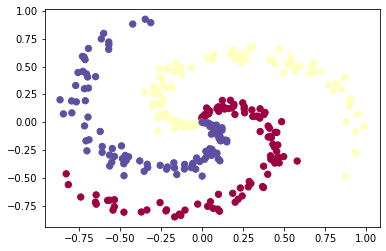

In [48]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline  

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

- `np.zeros` produces an ndarray of all 0's. The shape of the ndarray `np.zeros((N*K, D))` is $ (N\cdot K, D)$, that is dimension $ 1 $ has size $N\cdot K$ and dimension 2 has size $D$.
- `dtype='uint8'` refers to the data type of the array. `uint8` refers to as 
_unsigned 8-bit integer type_
- The `range` function produces a list of evenly-spaced integers, up to but not including the endpoint
- `np.linspace(0.0,1,N)` produces $ N $ evenly spaced numbers over a specified closed interval, from $ 0.0 $ to $ 1 $ 
- `r*np.sin(t)` is a multiplication of two equally sized ndarrays. The multiplication proceeds elementwise
- `np.c_` is stacking two arrays 'columnwise' together

Normally we would want to preprocess the dataset so that each feature has zero 
mean and unit standard deviation, but in this case the features are already 
in a nice range from $-1$ to $1$, so we skip this step.

# Training a Softmax Linear Classifier

## Initialize the parameters

Let us first train a Softmax classifier on this classification dataset. As we saw in the previous sections, the Softmax classifier has a linear score function and uses the cross-entropy loss. The parameters of the linear classifier consist of a weight matrix 
$ W $ and a  bias vector $ b $ for each class. Let us first initialize these 
parameters to be random numbers:

In [2]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))
print(W)
print(b)

[[-0.01070005  0.00291805  0.00511416]
 [ 0.00275707 -0.0032033   0.01106025]]
[[0. 0. 0.]]


- Recall that $ D = 2 $ is the dimensionality and $ K = 3 $ is 
the number of classes
- `np.random.randn(D,K)` produces an array of shape $ (D, K) $ 
consisting of standard normally distributed random numbers (with mean $ 0 $ and 
standard deviation $ 1 $.)

## Compute the Class Scores

Since this is a linear classifier, we can compute all class scores very simply in parallel with a single matrix multiplication:

In [3]:
# compute class scores for a linear classifier
scores = np.dot(X, W) + b
print(scores.shape)

(300, 3)


- `np.dot(X, W)` is the matrix product of $ X $ (a $300$ by $ 2 $ ndarray) and 
$  W $ (a $ 2 $ by $ 3 $ ndarray)
- In this example we have $ 300 $ $2$-D points, so after this multiplication 
the array `scores` will have shape $[300 \times 3] $, where each row gives the 
class scores corresponding to the $ 3 $ classes (blue, red, yellow).

## Compute the Loss

The second key ingredient we need is a loss function, which is a differentiable 
objective that quantifies our unhappiness with the computed class scores. 
Intuitively, we want the correct class to have a higher score than the other 
classes. When this is the case, the loss should be low and otherwise the loss 
should be high. 

There are many ways to quantify this intuition, but in this 
example let us use the _cross-entropy loss_ that is associated with the Softmax 
classifier. Recall that if $ z $ is the array of class scores for a single 
example (e.g. array of $ 3 $ numbers here), then the Softmax classifier 
computes the loss for that example as:


$$
L_i=-\log\left(\frac{e^{z_{y_i}}}{\sum_{j}e^{z_{j}}}\right)
$$

where $z_{y_i}$ denotes the element of the score array that represents to the 
correct class. We can see that the Softmax classifier interprets every element of $ z $ 
as holding the (unnormalized) log probabilities of the three classes. 
We exponentiate these to get (unnormalized) probabilities, and then 
normalize them to get probabilites. Therefore, the expression inside 
the $\log$ is the normalized probability of the correct class. 

Note how 
this expression works: this quantity is always between $ 0 $ and $ 1 $. 
When the probability of the correct class is very small (near $ 0 $), 
the loss will go towards (positive) infinity. Conversely, when the 
correct class probability goes towards $ 1 $, the loss will go towards 
zero because $ \log(1)=0 $. Hence, the expression for $L_i$ is low when 
the correct class probability is high, and it is very high when it is low.

Recall also that the full Softmax classifier loss is then defined as the 
average cross-entropy loss over the training examples and the regularization:

$$
L=\underbrace{\frac{1}{N}\sum L_i}_{\text{data loss}} + \underbrace{\frac{1}{2}\lambda \sum_{k}\sum_{l}W_{kl}^2}_{\text{regularization loss}}
$$


Given the array of __scores__ we have computed above, we can compute the loss. First, the way to obtain the probabilities is straight forward:


In [4]:
# Get unnormalized probabilities
exp_scores = np.exp(scores)
# Normalize them for each example
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
print(probs.shape)
print(probs[0:3])

(300, 3)
[[0.33333333 0.33333333 0.33333333]
 [0.33333417 0.33330942 0.33335641]
 [0.33334114 0.33328379 0.33337507]]


- Recall that `scores` has shape $[300 \times 3] $
- `np.exp()` is a _unary_ universal function, or _ufunc_. These functions perform elementwise operations on data in ndarrays. That is,  `exp_scores` 
has shape $[300 \times 3] $
- The function `np.sum(exp_scores, axis=1, keepdims=True)` computes the sum over 
axis $ 1 $. If `keepdims` is set to `True`, the axes which are reduced are 
left in the result as dimensions with size one. With this option, the 
result will broadcast correctly against the input array.

We now have an array `probs` of size $ [300 \times  3] $, where each row now 
contains the class probabilities. In particular, since we have normalized 
them every row now sums to one. We can now query for the log probabilities 
assigned to the correct classes in each example:

In [5]:
num_examples = X.shape[0]
correct_logprobs = -np.log(probs[range(num_examples),y])
print(correct_logprobs.shape)

(300,)


- The array `correct_logprobs` is a $1$D array of just the probabilities 
assigned to the correct classes for each example.
- Take a moment to understand, how the fancy indexing for the ndarray `probs` 
was carried out: the elements 
$ (0, y[0]), (1, y[1]), \ldots, (N*K-1, y[N*K-1]) $ were selected
- `np.log()` is a unary ufunc that evaluates the natural logarithm of the ndarray elementwise


The full loss is then the average of these log probabilities and the regularization loss:


In [6]:
# compute the loss: average cross-entropy loss and regularization
data_loss = np.sum(correct_logprobs)/(num_examples)
reg = 0.5
reg_loss = reg*np.sum(W*W)
loss = data_loss + reg_loss
print(loss)

1.1002045655032855


- Aggregations (often called _reductions_ ) like `sum` can either 
be used by calling the array instance method (`correct_logprobs.sum()`) or using the top level NumPy function `np.sum()`
- In this code, the regularization strength $\lambda $ is stored inside the `reg` .
The convenience factor of $0.5$ multiplying the regularization will become clear in 
a second. Evaluating this in the beginning (with random parameters) might give us 
`loss = 1.1`,  which is `np.log(1.0/3)` since with small initial random 
weights all probabilities assigned to all classes are about one third. 

We now want to make the loss as low as possible, with `loss = 0` as the 
absolute lower bound. But the lower the loss is, the higher are the probabilities 
assigned to the correct classes for all examples.

## Computing the Analytic Gradient with Backpropagation

We have a way of evaluating the loss, and now we have to minimize it. 
We will do so with gradient descent. That is, we start with random 
parameters (as shown above), and evaluate the gradient of the loss 
function with respect to the parameters, so that we know how we 
should change the parameters to decrease the loss. Let us introduce 
the intermediate variable $ p $, which is a vector of the (normalized) 
probabilities. The loss for one example is:

$$
p_{k} = \frac{e^{z_{k}}}{\sum_{j}e^{z_{j}}} \quad \quad L_i=-\log(p_{y_{i}})
$$

We now wish to understand how the computed scores inside $ z $ should change to 
decrease the loss $ L_i $ that this example contributes to the full objective. 
In other words, we want to derive the gradient $\frac{\partial{L_i}}{{\partial z_{k}}} $. 
The loss $ L_i $ is computed from $ p $, which in turn depends on $ z $. 
It is a fun exercise to the reader to use the chain rule to derive the gradient, 
but it turns out to be extremely simple and interpretable in the end, after a 
lot of things cancel out:

$$
\frac{\partial L_{i}}{\partial z_{k}}=p_{k} - \mathbb{1}\left(y_i=k\right)
$$

Notice how elegant and simple this expression is. Suppose the probabilities we 
computed were `p = [0.2, 0.3, 0.5]`, and that the correct class was the middle 
one (with probability $ 0.3 $). According to this derivation the gradient on 
the scores would be `dz = [0.2, -0.7, 0.5]`. Recalling what the interpretation 
of the gradient is, we see that this result is highly intuitive: increasing the 
first or last element of the score vector `z` (the scores of the incorrect classes) leads to an increased loss (due to the positive signs $+0.2$ and $+0.5$) - and increasing the loss is bad, as expected. However, increasing the score of the correct class has negative influence on the loss. The gradient of $-0.7$ is telling us that increasing the correct class score would lead to a decrease of the loss $L_i$, which makes sense.

All of this boils down to the following code. Recall that `probs` stores the 
probabilities of all classes (as rows) for each example. To get the gradient 
on the scores, which we call `dscores`, we proceed as follows:

In [7]:
dscores = probs
dscores[range(num_examples),y] -= 1
dscores /= num_examples
print(dscores.shape)

(300, 3)


- The fancy indexing for the ndarray `probs` was carried out as follows: the elements 
$ (0, y[0]), (1, y[1]), \ldots, (num\_examples-1, y[num\_examples-1]) $ were selected. That is, we subract $ 1$ from the probability corresponding to the true class and leaving the other probabilities unchanged.
- We divide `dscores` by `num_examples` because 
$$
L=\underbrace{\frac{1}{N}\sum L_i}_{\text{data loss}} + \underbrace{\frac{1}{2}\lambda \sum_{k}\sum_{l}W_{kl}^2}_{\text{regularization loss}}
$$
so we need to divide by the number of data points.

Lastly, we had that `scores = np.dot(X, W) + b`, so armed with the 
gradient on `scores` (stored in `dscores`), we can now backpropagate 
into $ W $ and $ b $:

In [8]:
dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
print(db.shape)
dW += reg*W # don't forget the regularization gradient
print(dW.shape)

(1, 3)
(2, 3)


- `X.T` denotes the transpose of $X$ and has shape $(2, 300)$. 
`dscores` has shape $(300, 3)$. Thus, `dW` has shape $(2, 3)$ which is of course identical to 
the shape of `W`
- We see that we have backpropped through the matrix multiply operation, 
and also added the contribution from the regularization. Note that the 
regularization gradient has the very simple form `reg*W` since we 
used the constant $ 0.5 $ for its loss 
contribution, i.e.

$$
\frac{d}{dw}\left(\frac{1}{2}\lambda w^2\right)=\lambda w
$$

This is a common convenience trick that simplifies the gradient expression.

`dW` is actually a short-hand notation for the Jacobian

$$
\frac{\partial L}{\partial W_{ij}}
$$

## Performing a Parameter Update

Now that we have evaluated the gradient we know how every parameter 
influences the loss function. We will now perform a parameter update 
in the negative gradient direction to decrease the loss:

Putting all of this together, here is the full code for training a 
Softmax classifier with Gradient descent:


# Putting it All Together: Training a Softmax Classifier

In [9]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):
  
  # evaluate class scores, [N x K]
  scores = np.dot(X, W) + b 
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  # [N x K]
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 
  
  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)
  
  dW += reg*W # regularization gradient
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db

iteration 0: loss 1.096855
iteration 10: loss 0.904739
iteration 20: loss 0.832449
iteration 30: loss 0.798906
iteration 40: loss 0.781066
iteration 50: loss 0.770702
iteration 60: loss 0.764307
iteration 70: loss 0.760188
iteration 80: loss 0.757447
iteration 90: loss 0.755580
iteration 100: loss 0.754282
iteration 110: loss 0.753367
iteration 120: loss 0.752713
iteration 130: loss 0.752242
iteration 140: loss 0.751899
iteration 150: loss 0.751648
iteration 160: loss 0.751463
iteration 170: loss 0.751326
iteration 180: loss 0.751224
iteration 190: loss 0.751148


We could verify that we have converged to something after about $ 190 $ iterations. We can evaluate the training set accuracy:

In [10]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.53


- `np.argmax` returns the indices of the maximum values along an axis. 

This prints $ 55\% $. Not very good at all, but also not surprising 
given that the dataset is constructed so it is not linearly separable. We can also plot the 
learned decision boundaries:

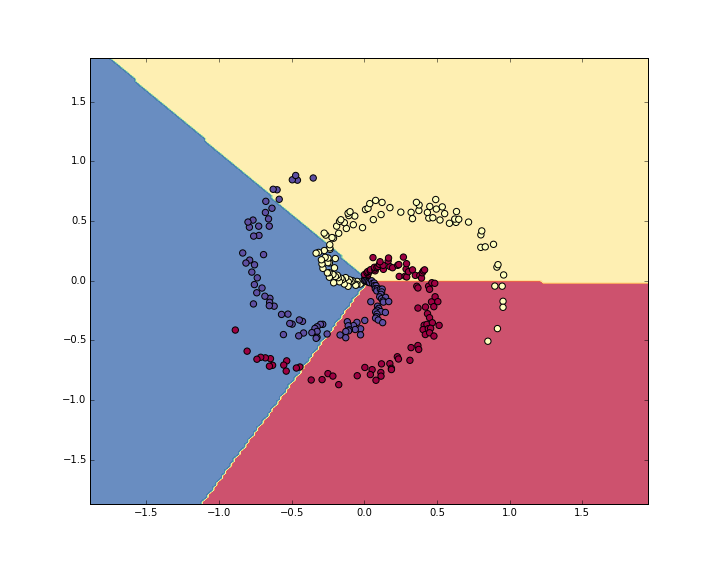

# Training a Neural Network

Clearly, a linear classifier is inadequate for this dataset and we would like to use a Neural Network. One additional hidden layer will suffice for this toy data. We will now need two sets of weights and biases (for the first and second layers):


In [11]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

The forward pass to compute scores now changes form:

In [12]:
# evaluate class scores with a 2-layer Neural Network
hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
print(hidden_layer.shape)
scores = np.dot(hidden_layer, W2) + b2
print(scores.shape)

(300, 100)
(300, 3)


- Remember $X$ has shape $(num\_examples, D)$, $ W $ has shape $(D, h)$, thus 
`hidden_layer` has shape $(num\_examples, h)$.

Notice that the only change from before is one extra line of code, where 
we first compute the hidden layer representation and then the scores based 
on this hidden layer. Crucially, we have also added a non-linearity, which 
in this case is simple ReLU that thresholds the activations on the hidden layer 
at zero.

Everything else remains the same. We compute the loss based on the scores 
exactly as before, and get the gradient for the scores `dscores` exactly as 
before. However, the way we backpropagate that gradient into the model 
parameters now changes form, of course. First let us backpropagate the 
second layer of the Neural Network. This looks identical to the code 
we had for the Softmax classifier, except we are replacing $X$ (the raw data), with the variable 
`hidden_layer`):


In [13]:
# backpropate the gradient to the parameters
# first backprop into parameters W2 and b2
dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)
print(dW2.shape)
print(db2.shape)

(100, 3)
(1, 3)


- `hidden_layer.T` is the transpose of `hidden_layer`, and thus has 
shape $(h, num\_examples)$. `dscores` has shape $(num\_examples, 3)$. 
And `dW2` thus has shape $(h, 3)$

However, unlike before we are not yet done, because `hidden_layer` is 
itself a function of other parameters and the data! We need to continue
backpropagation through this variable. Its gradient can be computed as:

In [14]:
dhidden = np.dot(dscores, W2.T)
print(dhidden.shape)

(300, 100)


`dhidden` has shape $(num\_examples, h)$. 

Now we have the gradient on the outputs of the hidden layer. Next, we have to backpropagate the ReLU non-linearity. This turns out to be easy because ReLU during the backward pass is effectively a switch. Since 

$$
r=\max(0, x)
$$

we have that 

$$
\frac{dr}{dx}=\mathbb{1}(x>0)
$$

Combined with the chain rule, we see that the ReLU unit lets the gradient pass through unchanged if its input was greater than $ 0 $, but _kills_ it if its input was less than zero during the forward pass. Hence, we can backpropagate the ReLU in place simply with:

In [15]:
# backprop the ReLU non-linearity
dhidden[hidden_layer <= 0] = 0

And now we finally continue to the first layer weights and biases:

In [16]:
# finally into W,b
dW = np.dot(X.T, dhidden)
db = np.sum(dhidden, axis=0, keepdims=True)

We are done! We have the gradients $ dW,db,dW2,db2$ and can perform the parameter update. Everything else remains unchanged. The full code looks very similar:

In [17]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropagate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2


iteration 0: loss 1.098735
iteration 1000: loss 0.269135
iteration 2000: loss 0.246575
iteration 3000: loss 0.243476
iteration 4000: loss 0.241899
iteration 5000: loss 0.239853
iteration 6000: loss 0.236885
iteration 7000: loss 0.234191
iteration 8000: loss 0.233626
iteration 9000: loss 0.233423


The training accuracy is now:

In [19]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.99


Which prints $99\%$ We can also visualize the decision boundaries:

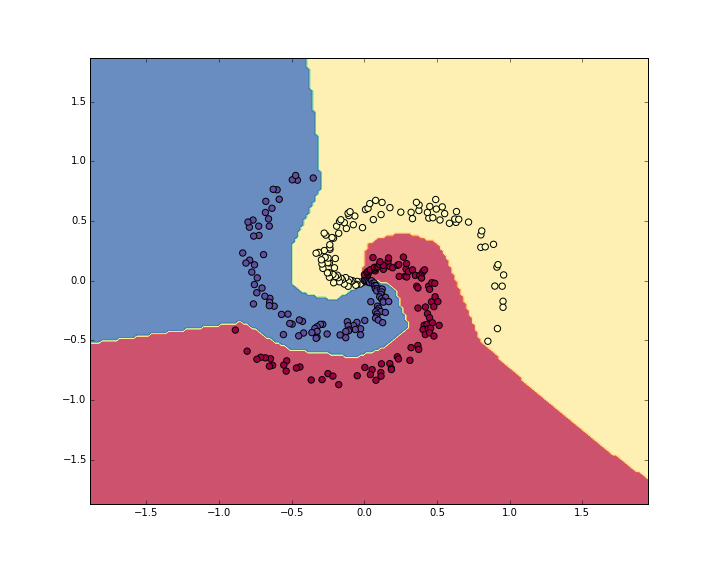

# Part II : Toy Neural Network with Keras

_Keras_ is a deep-learning framework for Python that provides a convenient way to define and train almost any kind of deep-learning model. Keras was initially developed for researchers, with the aim of enabling fast experimentation. 

Keras has the following features:

- It allows the same code to run seamlessly on CPU or GPU
- It has a user-friendly API that makes it easy to quickly prototype deep-learning models
- It has built-in support for convolutional networks (for computer vision), recurrent networks (for sequence processing), and any combination of both.
- It supports arbitrary network architectures: multi-input oder multi-output models, layer sharing, model sharing, and so on. This means Keras is appropriate for building essentially any deep-learning model, from a generative adversarial network to a neural Turing machine.

Keras is also a popular framework on Kaggle, the machine-learning competition website, where almost every recent deep-learning competition has been won using Keras models.

Keras is a model-level library, providing high-level building blocks for developing deep-learning models. It does not handle low-level operations such as tensor manipulations and 
differentiation. Via TensorFlow (or Theano, or CNTK), Keras is able to run seamlessly on both CPUs and GPUs. When running on CPU, TensorFlow is itself wrapping a low-level library for tensor operations called Eigen. On GPU, TensorFlow wraps a library of well-optimized deep-learning operations called the NVIDIA CUDA Deep Neural Network library (cuDNN).

The typical Keras workflow looks as follows:

1. Define your training data : input tensors and target tensors
2. Define a network of layers (or _model_ ) that maps your inputs to your targets.
3. Configure the learning process by choosing a loss function, an optimizer, and some metrics to monitor.
4. Iterate on your training data by calling the `fit()` method of your model.

In [20]:
# Import TensorFlow 
import tensorflow as tf

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt


print(tf.__version__)



2.1.0


## 1. Define Your Network

The `tf.keras.models.Sequential` class is a wrapper for the neural network model that treats 
the network as a sequence of layers. It implements the Keras model interface with common 
methods like `compile()`, `fit()`, and `evaluate()` that are used to train and 
run the model. We'll cover these functions soon, but first let's start looking at the layers of the model.

#### Layers

The Keras Layer class provides a common interface for a variety of standard neural network layers. You can add a layer to a model using the 
model's `add()` method. For example, a simple model with a single hidden layer might look like this for the spiral dataset:

In [21]:
model = tf.keras.Sequential()
# From Input to first hidden layer
model.add(tf.keras.layers.Dense(100, activation= tf.nn.relu, 
                                input_shape=(2,)))
# From first hidden layer to output layer
model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

## 2. Compile Network


Once we have our model built, we need to compile it before it can be run. Compiling the Keras 
model calls the backend (tensorflow, theano, etc.) and binds the optimizer, loss function, 
and other parameters required before the model can be run on any input data. We'll specify the 
loss function to be `categorical_crossentropy`, 
and specify `adam` as the optimizer (which is a reasonable default when speed is a priority). And finally, 
we can specify what metrics we want to evaluate the model with. Here we'll use `accuracy`.


In [22]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
X.shape

(300, 2)

We can see the resulting model architecture with the following command:

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               300       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 603
Trainable params: 603
Non-trainable params: 0
_________________________________________________________________


## 3. Fit Network

The model is trained with the `fit()` method, through the following command that specifies the 
number of training epochs and the message level (how much information we want displayed on the screen 
during training).

Before starting, we need to one-hot-encode the labels.


In [24]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='uint8')
    result[np.arange(len(vector)), vector] = 1
    return result
print(convertToOneHot([2,1,0], 3))

# One-hot-encoded labels of spiral datset
y_cat = convertToOneHot(y,3)
print(y_cat[:3])

[[0 0 1]
 [0 1 0]
 [1 0 0]]
[[1 0 0]
 [1 0 0]
 [1 0 0]]


or alternatively

In [25]:
from tensorflow.keras import utils
y_cat = utils.to_categorical(y, 3)
print(y_cat[:3])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [26]:
BATCH_SIZE=128
num_train_examples = X.shape[0]
num_train_examples
model.fit(X, y_cat, epochs=1000, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train on 300 samples
Epoch 1/1000
300/300 [==============================] - 1s 5ms/sample - loss: 1.0747 - accuracy: 0.4233
Epoch 2/1000
300/300 [==============================] - 0s 31us/sample - loss: 1.0628 - accuracy: 0.4833
Epoch 3/1000
300/300 [==============================] - 0s 36us/sample - loss: 1.0505 - accuracy: 0.5067
Epoch 4/1000
300/300 [==============================] - 0s 30us/sample - loss: 1.0385 - accuracy: 0.5233
Epoch 5/1000
300/300 [==============================] - 0s 38us/sample - loss: 1.0271 - accuracy: 0.5367
Epoch 6/1000
300/300 [==============================] - 0s 32us/sample - loss: 1.0159 - accuracy: 0.5300
Epoch 7/1000
300/300 [==============================] - 0s 34us/sample - loss: 1.0045 - accuracy: 0.5267
Epoch 8/1000
300/300 [==============================] - 0s 30us/sample - loss: 0.9938 - accuracy: 0.5233
Epoch 9/1000
300/300 [==============================] - 0s 26us/sample - loss: 0.9829 - accuracy: 0.5367
Epoch 10/1000
300/300 [============

## 4. Evaluate Network

Finally, we can use the following command to evaluate the model:

In [28]:
test_loss, test_accuracy = model.evaluate(X, y_cat, steps=math.ceil(num_train_examples/32))
print('Accuracy on test dataset:', test_accuracy)

300/300 [==============================] - 0s 50us/sample - loss: 0.0563 - accuracy: 0.9900
Accuracy on test dataset: 0.99


# Part 3 : Keras for MNIST

In [32]:
!pip install tensorflow-datasets

You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


In [33]:
!pip install tfds-nightly

     |████████████████████████████████| 3.7 MB 6.8 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3 -m pip install --upgrade pip' command.


In [34]:
from __future__ import absolute_import, division, print_function, unicode_literals


# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt


print(tf.__version__)


2.1.0


In [35]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [36]:
dataset, metadata = tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset mnist downloaded and prepared to /home/jovyan/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [37]:
class_names = ['zero', 'one', 'two', 'three', 'four',
               'five',      'six',   'seven',  'eight',   'nine']

In [38]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [39]:
i=0
for (image, label) in train_dataset.take(3000):
    if i==0:
        X_train = image.numpy().reshape((1,28*28))
        y_train = np.array([label])
    else:
        X_train = np.concatenate([X_train, image.numpy().reshape((1,28*28))], axis=0)
        y_train = np.concatenate([y_train, np.array([label])], axis=0)
    i+=1
print("Shape of image training data : ", X_train.shape)
print("Shape of training data labels : ", y_train.shape)

Shape of image training data :  (3000, 784)
Shape of training data labels :  (3000,)


## 1. Define Networks

Building the neural network requires configuring the layers of the model, then compiling the model.


#### Setup the layers

The basic building block of a neural network is the *layer*. A layer extracts a representation from the data fed into it. Hopefully, a series of connected layers results in a representation that is meaningful for the problem at hand.

Much of deep learning consists of chaining together simple layers. Most layers, like `tf.keras.layers.Dense`, have internal parameters which are adjusted ("learned") during training.

In [40]:
model = tf.keras.Sequential()
# From Input to first hidden layer
model.add(tf.keras.layers.Dense(500, activation= tf.nn.sigmoid, 
                                batch_input_shape=(None,784)))
model.add(tf.keras.layers.Dense(50,  activation=tf.nn.sigmoid))
model.add(tf.keras.layers.Dense(10,  activation=tf.nn.softmax))          



This network has three layers:



* **"hidden"** `tf.keras.layers.Dense`— A densely connected layer of 500 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

* **"hidden"** `tf.keras.layers.Dense`— A densely connected layer of 50 neurons. Each neuron (or node) takes input from all 500 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer.

* **output** `tf.keras.layers.Dense` — A 10-node *softmax* layer, with each node representing a class of clothing. As in the previous layer, each node takes input from the 50 nodes in the layer before it. Each node weights the input according to learned parameters, and then outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.


## 2. Compile Networks


Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:


* *Loss function* — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
* *Optimizer* —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
* *Metrics* —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [41]:
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_3 (Dense)              (None, 50)                25050     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
Total params: 418,060
Trainable params: 418,060
Non-trainable params: 0
_________________________________________________________________


# 3. Fit Network

Training is performed by calling the `model.fit` method:


In [43]:
from tensorflow.keras import utils
y_cat = utils.to_categorical(y_train)
print(X_train.shape)
print(y_cat.shape)

# Model evaluation of untrained model
loss, accuracy = model.evaluate(X_train[0:2000], y_cat[0:2000])
print('Accuracy :', accuracy)
print('Loss :', loss)



(3000, 784)
(3000, 10)
2000/2000 [==============================] - 0s 164us/sample - loss: 2.4660 - accuracy: 0.0735
Accuracy : 0.0735
Loss : 2.465993377685547


In [44]:
history = model.fit(X_train[0:2400], y_cat[0:2400], epochs=300, batch_size=32, validation_data=[X_train[2400:3000], y_cat[2400:3000]])

Train on 2400 samples, validate on 600 samples
Epoch 1/300
2400/2400 [==============================] - 1s 314us/sample - loss: 2.4652 - accuracy: 0.0712 - val_loss: 2.4392 - val_accuracy: 0.0883
Epoch 2/300
2400/2400 [==============================] - 0s 154us/sample - loss: 2.4564 - accuracy: 0.0712 - val_loss: 2.4318 - val_accuracy: 0.0867
Epoch 3/300
2400/2400 [==============================] - 0s 155us/sample - loss: 2.4481 - accuracy: 0.0721 - val_loss: 2.4247 - val_accuracy: 0.0867
Epoch 4/300
2400/2400 [==============================] - 0s 147us/sample - loss: 2.4400 - accuracy: 0.0733 - val_loss: 2.4177 - val_accuracy: 0.0900
Epoch 5/300
2400/2400 [==============================] - 0s 149us/sample - loss: 2.4321 - accuracy: 0.0746 - val_loss: 2.4110 - val_accuracy: 0.0883
Epoch 6/300
2400/2400 [==============================] - 0s 150us/sample - loss: 2.4245 - accuracy: 0.0746 - val_loss: 2.4044 - val_accuracy: 0.0883
Epoch 7/300
2400/2400 [==============================] - 0s

##  4. Evaluate Network

In [45]:
loss, accuracy = model.evaluate(X_train[2400:3000], y_cat[2400:3000])
print('Accuracy :', accuracy)

600/600 [==============================] - 0s 81us/sample - loss: 1.7646 - accuracy: 0.6000
Accuracy : 0.6


## 5. Make Predictions

In [50]:
model.predict_classes(X_train[2500:2510])

array([0, 3, 3, 2, 5, 8, 7, 3, 3, 3])

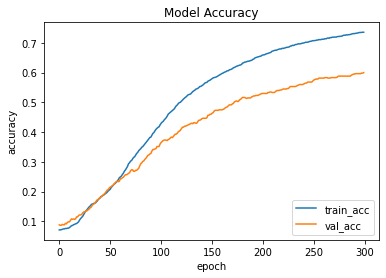

In [47]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline  
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_acc', 'val_acc'], loc='lower right')
plt.show()